# Testing Longformer on test set

In [ ]:
import jsonlines
import torch
import torch.nn as nn
import numpy as np
from transformers import LongformerModel, LongformerTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sentence_transformers import SentenceTransformer, util
import os
import nltk
from nltk.tokenize import sent_tokenize
import evaluate
from collections import defaultdict

# Download NLTK punkt tokenizer
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

def nltk_sent_tokenize(text):
    """Splits text into sentences using NLTK."""
    return sent_tokenize(text)

def get_token_f1_score(candidate_tokens, reference_tokens):
    """Computes a token-based F1 score between a candidate and reference sentence."""
    candidate_tokens_set = set(candidate_tokens)
    reference_tokens_set = set(reference_tokens)
    if not candidate_tokens_set or not reference_tokens_set:
        return 0.0
    intersection = len(candidate_tokens_set.intersection(reference_tokens_set))
    precision = intersection / len(candidate_tokens_set)
    recall = intersection / len(reference_tokens_set)
    if precision + recall == 0:
        return 0.0
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

# ==============================================================================
# 1. Custom Model Definition for Longformer
# ==============================================================================
class LongformerExtractiveSummarizationModel(nn.Module):
    """A custom PyTorch model for extractive summarization using a Longformer backbone."""
    def __init__(self, pos_weight=None):
        super(LongformerExtractiveSummarizationModel, self).__init__()
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(self.longformer.config.hidden_size, 1)
        self.pos_weight = pos_weight if pos_weight is not None else torch.tensor(1.0)

    def forward(self, input_ids=None, attention_mask=None, global_attention_mask=None, labels=None):
        outputs = self.longformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            global_attention_mask=global_attention_mask
        )
        sequence_output = outputs.last_hidden_state
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        logits = logits.squeeze(-1)
        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
            loss = loss_fct(logits, labels.float())
        return (loss, logits) if loss is not None else logits

# ==============================================================================
# 2. Configuration
# ==============================================================================
DATA_DIR = "govreport_tfidf_vscode2"
NUM_TEST_SAMPLES = 200
F1_THRESHOLD = 0.3
CHUNK_SIZE = 4096
test_file = f"{DATA_DIR}/test.json"
CHECKPOINT_DIR = "./extractive_summarization_results/"

# ==============================================================================
# 3. Data Loading and Preprocessing
# ==============================================================================
def load_jsonl_data(file_path, max_samples=None):
    """Loads a JSON Lines file and returns a list of dictionaries."""
    data = []
    with jsonlines.open(file_path) as reader:
        for i, obj in enumerate(reader):
            if max_samples and i >= max_samples:
                break
            data.append(obj)
    return data

print(f"Loading {NUM_TEST_SAMPLES} samples from the test file...")
test_data_raw = load_jsonl_data(test_file, max_samples=NUM_TEST_SAMPLES)

def preprocess_data(data):
    """Processes raw data, validates inputs, and precomputes sentence embeddings."""
    sent_model = SentenceTransformer('all-MiniLM-L6-v2')
    processed_samples = []
    for i, item in enumerate(data):
        original_text = item.get('original_text', '')
        extractive_summary = item.get('extractive_summary', '')
        if not isinstance(original_text, str) or not original_text.strip():
            continue
        if not isinstance(extractive_summary, str) or not extractive_summary.strip():
            continue
        document_sentences = nltk_sent_tokenize(original_text)
        sentence_embeddings = sent_model.encode(document_sentences, convert_to_numpy=True).tolist()
        processed_samples.append({
            'document': original_text,
            'extractive_summary': extractive_summary,
            'id': i,
            'document_sentences': document_sentences,
            'sentence_embeddings': sentence_embeddings
        })
    print(f"Processed {len(processed_samples)} valid samples out of {len(data)}")
    return processed_samples

test_data = preprocess_data(test_data_raw)

# ==============================================================================
# 4. Tokenization and Dataset Creation
# ==============================================================================
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

def tokenize_and_align_labels(examples, f1_threshold=F1_THRESHOLD):
    """Tokenizes documents without truncation, creates hierarchical chunks, and aligns labels."""
    print("f1_threshold", f1_threshold)
    all_input_ids = []
    all_attention_mask = []
    all_global_attention_mask = []
    all_labels = []
    all_document_id = []

    for idx, (doc, summary, doc_id, doc_sentences) in enumerate(zip(
        examples['document'], examples['extractive_summary'], examples['id'], examples['document_sentences']
    )):
        print(f"Processing test document {idx} (ID: {doc_id})...")
        if not doc or not summary:
            continue

        summary_sentences = nltk_sent_tokenize(summary)
        if not doc_sentences or not summary_sentences:
            continue

        tokenized_summary_sentences = [tokenizer.tokenize(s) for s in summary_sentences]
        sentence_labels = []
        tokenized_doc_sentences = []
        for doc_sentence in doc_sentences:
            doc_sent_tokens = tokenizer.tokenize(doc_sentence)
            tokenized_doc_sentences.append(tokenizer.encode(doc_sentence, add_special_tokens=False))
            max_f1 = max(get_token_f1_score(doc_sent_tokens, sum_sent_tokens) for sum_sent_tokens in tokenized_summary_sentences) if tokenized_summary_sentences else 0.0
            sentence_labels.append(1.0 if max_f1 >= f1_threshold else 0.0)

        current_input_ids = [tokenizer.cls_token_id]
        current_attention_mask = [1]
        current_labels = [0.0]
        current_sent_idx = 0

        while current_sent_idx < len(doc_sentences):
            while current_sent_idx < len(doc_sentences):
                sent_tokens = tokenized_doc_sentences[current_sent_idx]
                if len(current_input_ids) + len(sent_tokens) + 1 > CHUNK_SIZE:
                    break
                current_input_ids += sent_tokens
                current_attention_mask += [1] * len(sent_tokens)
                current_labels += [sentence_labels[current_sent_idx]] * len(sent_tokens)
                current_sent_idx += 1

            if len(current_input_ids) > 1:
                current_input_ids.append(tokenizer.sep_token_id)
                current_attention_mask.append(1)
                current_labels.append(0.0)

                padding_length = CHUNK_SIZE - len(current_input_ids)
                if padding_length > 0:
                    current_input_ids += [tokenizer.pad_token_id] * padding_length
                    current_attention_mask += [0] * padding_length
                    current_labels += [0.0] * padding_length

                global_attention_mask = [0] * len(current_input_ids)
                global_attention_mask[0] = 1

                all_input_ids.append(current_input_ids)
                all_attention_mask.append(current_attention_mask)
                all_global_attention_mask.append(global_attention_mask)
                all_labels.append(current_labels)
                all_document_id.append(doc_id)

            if current_sent_idx < len(doc_sentences):
                current_input_ids = [tokenizer.cls_token_id]
                current_attention_mask = [1]
                current_labels = [0.0]

        if not all_input_ids or len(all_input_ids[-1]) < 10:
            continue

    return {
        'input_ids': all_input_ids,
        'attention_mask': all_attention_mask,
        'global_attention_mask': all_global_attention_mask,
        'labels': all_labels,
        'document_id': all_document_id
    }

test_dataset = Dataset.from_dict({
    'document': [item['document'] for item in test_data],
    'extractive_summary': [item['extractive_summary'] for item in test_data],
    'id': [item['id'] for item in test_data],
    'document_sentences': [item['document_sentences'] for item in test_data],
    'sentence_embeddings': [item['sentence_embeddings'] for item in test_data]
})
test_dataset_tokenized = test_dataset.map(
    lambda examples: tokenize_and_align_labels(examples, F1_THRESHOLD),
    batched=True,
    batch_size=4,
    remove_columns=["document", "extractive_summary", "id", "document_sentences", "sentence_embeddings"],
    desc="Tokenizing test data",
    num_proc=4
)

def is_valid_example(example):
    if not isinstance(example['input_ids'], list) or not example['input_ids']:
        return False
    if len(example['input_ids']) != len(example['attention_mask']) or \
       len(example['input_ids']) != len(example['global_attention_mask']) or \
       len(example['input_ids']) != len(example['labels']):
        return False
    if 'document_id' not in example:
        return False
    return True

test_dataset_tokenized = test_dataset_tokenized.filter(is_valid_example, desc="Filtering invalid test examples")
print(f"Test dataset size: {len(test_dataset_tokenized)}")
if len(test_dataset_tokenized) == 0:
    raise ValueError("Test dataset is empty after processing.")

# ==============================================================================
# 5. Load Trained Model
# ==============================================================================
# Find the latest checkpoint with a valid model file
latest_checkpoint = None
model_file = None
if os.path.exists(CHECKPOINT_DIR):
    checkpoints = [d for d in os.listdir(CHECKPOINT_DIR) if d.startswith("checkpoint-")]
    if checkpoints:
        for checkpoint in sorted(checkpoints, key=lambda x: int(x.split("-")[1]), reverse=True):
            checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint)
            for file_name in ["pytorch_model.bin", "model.bin", "model.safetensors"]:
                model_path = os.path.join(checkpoint_path, file_name)
                if os.path.exists(model_path):
                    latest_checkpoint = checkpoint_path
                    model_file = file_name
                    break
            if latest_checkpoint:
                break
        if latest_checkpoint is None:
            raise FileNotFoundError(f"No valid model file (e.g., pytorch_model.bin, model.bin, model.safetensors) found in any checkpoint. Available checkpoints and files: {[(c, os.listdir(os.path.join(CHECKPOINT_DIR, c))) for c in checkpoints]}")
    else:
        raise ValueError(f"No checkpoints found in {CHECKPOINT_DIR}. Available directories: {os.listdir(CHECKPOINT_DIR)}")
else:
    raise ValueError(f"Checkpoint directory {CHECKPOINT_DIR} does not exist")

# Calculate pos_weight for consistency
def calculate_pos_weight(dataset):
    """Calculates pos_weight based on the ratio of negative to positive labels."""
    pos_count = 0
    neg_count = 0
    for example in dataset:
        labels = example['labels']
        pos_count += sum(1 for label in labels if label == 1.0)
        neg_count += sum(1 for label in labels if label == 0.0)
    pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
    return torch.tensor(pos_weight)

pos_weight = calculate_pos_weight(test_dataset_tokenized)
print(f"Calculated pos_weight: {pos_weight.item():.2f}")
latest_checkpoint = "./extractive_summarization_results/checkpoint-3148"
# Load the model from the checkpoint
print(f"Loading model from {latest_checkpoint} using {model_file}...")
model = LongformerExtractiveSummarizationModel(pos_weight=pos_weight)
if model_file == "model.safetensors":
    from safetensors.torch import load_file
    model.load_state_dict(load_file(os.path.join(latest_checkpoint, model_file)))
else:
    model.load_state_dict(torch.load(os.path.join(latest_checkpoint, model_file)))
model.eval()

# Calculate average reference summary length for dynamic top_k
def calculate_avg_summary_sentences(data):
    """Calculates the average number of sentences in reference summaries."""
    total_sentences = sum(len(nltk_sent_tokenize(item['extractive_summary'])) for item in data)
    return max(1, round(total_sentences / len(data)))

avg_summary_sentences = calculate_avg_summary_sentences(test_data)
print(f"Average reference summary sentences: {avg_summary_sentences}")

# ==============================================================================
# 6. Evaluation Metrics
# ==============================================================================
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")
from bert_score import score as bert_score

def compute_metrics(eval_pred, raw_data, tokenizer_obj, eval_dataset, top_k=avg_summary_sentences, lambda_mmr=1):
    print("lambda_mmr", lambda_mmr)
    logits, labels = eval_pred
    predictions = torch.sigmoid(torch.from_numpy(logits))
    predictions_binary = (predictions > 0.5).numpy().astype(int)

    labels_flat = labels.flatten()
    predictions_flat = predictions_binary.flatten()

    metrics = {}
    if len(labels_flat) > 0:
        metrics["f1"] = f1_score(labels_flat, predictions_flat, average='binary', zero_division=0)
        metrics["precision"] = precision_score(labels_flat, predictions_flat, average='binary', zero_division=0)
        metrics["recall"] = recall_score(labels_flat, predictions_flat, average='binary', zero_division=0)
        metrics["accuracy"] = accuracy_score(labels_flat, predictions_flat)
    else:
        metrics["f1"] = 0.0
        metrics["precision"] = 0.0
        metrics["recall"] = 0.0
        metrics["accuracy"] = 0.0

    predicted_summaries = []
    reference_summaries = []

    doc_logits = defaultdict(list)
    doc_attention = defaultdict(list)
    for i, doc_id in enumerate(eval_dataset['document_id']):
        doc_logits[doc_id].append(predictions[i].numpy())
        doc_attention[doc_id].append(eval_dataset['attention_mask'][i])

    for doc_id in sorted(doc_logits.keys()):
        chunks = doc_logits[doc_id]
        att_masks = doc_attention[doc_id]
        reference_summaries.append(raw_data[doc_id]['extractive_summary'])
        document = raw_data[doc_id]['document']
        sentence_embeddings = np.array(raw_data[doc_id]['sentence_embeddings'])

        aggregated_scores = []
        for chunk, att_mask in zip(chunks, att_masks):
            effective_len = sum(att_mask)
            if effective_len < 3:
                continue
            content_scores = chunk[1:effective_len - 1]
            aggregated_scores.extend(content_scores)

        document_sentences = nltk_sent_tokenize(document)
        sentence_scores = []
        tokenized_doc_sentences = [tokenizer_obj.encode(s, add_special_tokens=False) for s in document_sentences]

        start_index = 0
        for sent_tokens in tokenized_doc_sentences:
            end_index = start_index + len(sent_tokens)
            if end_index > len(aggregated_scores):
                break
            sentence_logits = aggregated_scores[start_index:end_index]
            sentence_scores.append(np.max(sentence_logits) if len(sentence_logits) > 0 else 0.0)
            start_index = end_index

        # Remove MMR and select top-k sentences based on scores
        selected_indices = np.argsort(sentence_scores)[-top_k:][::-1]

        predicted_sentences = [document_sentences[i] for i in selected_indices]
        if not predicted_sentences and document_sentences:
            predicted_sentences.append(document_sentences[0])

        predicted_summaries.append(" ".join(predicted_sentences))

    # ROUGE
    rouge_results = rouge_metric.compute(predictions=predicted_summaries, references=reference_summaries, use_stemmer=True)
    rouge1_val = rouge_results["rouge1"]
    rouge2_val = rouge_results["rouge2"]
    rougeL_val = rouge_results["rougeL"]
    metrics.update({
        "rouge1": rouge1_val.mid.fmeasure if hasattr(rouge1_val, 'mid') else rouge1_val,
        "rouge2": rouge2_val.mid.fmeasure if hasattr(rouge2_val, 'mid') else rouge2_val,
        "rougeL": rougeL_val.mid.fmeasure if hasattr(rougeL_val, 'mid') else rougeL_val,
    })

    # METEOR
    meteor_result = meteor_metric.compute(predictions=predicted_summaries, references=reference_summaries)
    metrics["meteor"] = meteor_result["meteor"]

    # BERTScore
    P, R, F1 = bert_score(predicted_summaries, reference_summaries, lang="en", model_type="bert-base-uncased")
    metrics["bertscore_precision"] = P.mean().item()
    metrics["bertscore_recall"] = R.mean().item()
    metrics["bertscore_f1"] = F1.mean().item()

    return metrics

# ==============================================================================
# 7. Setup Trainer for Testing
# ==============================================================================
training_args = TrainingArguments(
    output_dir=CHECKPOINT_DIR,
    per_device_eval_batch_size=4,
    fp16=torch.cuda.is_available(),
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset_tokenized,
    compute_metrics=lambda p: compute_metrics(p, test_data, tokenizer, test_dataset_tokenized, top_k=avg_summary_sentences),
    tokenizer=tokenizer,
)

# ==============================================================================
# 8. Evaluate the Model
# ==============================================================================
print("Starting evaluation...")
metrics = trainer.evaluate()
print("Evaluation finished.")
print(f"Test Metrics: {metrics}")

## Results

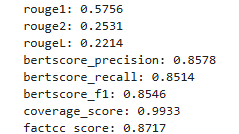